<a href="https://colab.research.google.com/github/Daps2831/Machine-Learning/blob/main/UAS/UAS_ML_Daffa_Klasifikasi_Ikan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount File

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Ganti 'path/ke/dataset.zip' dengan path file zip Anda di Google Drive
# Contoh: '/content/drive/MyDrive/Types of fish.zip'
!cp '/content/drive/MyDrive/Dataset/Types_of_fish.zip' /content/

# Ekstrak file zip di lingkungan Colab.
# Opsi -q (quiet) agar tidak menampilkan nama semua file yang diekstrak.
!unzip -q /content/Types_of_fish.zip -d /content/

# Buat dataset ke dataframe panda

In [21]:
import pandas as pd
import os

# Tentukan path ke direktori utama dataset Anda
base_dir = "/content/Types of fish/FishImgDataset" # Ganti dengan path Anda

# Siapkan list kosong untuk menampung data
data = []

# Loop melalui setiap set (train, val, test)
for dataset_type in ['train', 'val', 'test']:
    dataset_path = os.path.join(base_dir, dataset_type)

    # Dapatkan semua nama kelas (subfolder) di dalam folder train/val/test
    # Asumsi nama kelas ada di dalam folder train dan val
    if dataset_type in ['train', 'val']:
        class_names = os.listdir(dataset_path)
        for class_name in class_names:
            class_path = os.path.join(dataset_path, class_name)

            # Pastikan itu adalah direktori
            if os.path.isdir(class_path):
                image_files = os.listdir(class_path)
                for image_name in image_files:
                    image_path = os.path.join(class_path, image_name)
                    data.append({
                        'filepath': image_path,
                        'label': class_name,
                        'dataset': dataset_type
                    })
    # Untuk folder test, biasanya tidak ada subfolder kelas
    else:
        # Add a check if the directory exists before listing files
        if os.path.isdir(dataset_path):
            image_files = os.listdir(dataset_path)
            for image_name in image_files:
                image_path = os.path.join(dataset_path, image_name)
                data.append({
                    'filepath': image_path,
                    'label': 'unknown', # Label untuk test set bisa diisi 'unknown'
                    'dataset': dataset_type
                })


# Buat DataFrame dari list yang sudah kita kumpulkan
df = pd.DataFrame(data)

# Tampilkan beberapa baris pertama untuk memeriksa
print(df.head())

# Tampilkan informasi umum tentang dataframe
print("\nInfo DataFrame:")
df.info()
print(df.head(10).to_markdown(index=False))

                                            filepath   label dataset
0  /content/Types of fish/FishImgDataset/train/Ba...  Bangus   train
1  /content/Types of fish/FishImgDataset/train/Ba...  Bangus   train
2  /content/Types of fish/FishImgDataset/train/Ba...  Bangus   train
3  /content/Types of fish/FishImgDataset/train/Ba...  Bangus   train
4  /content/Types of fish/FishImgDataset/train/Ba...  Bangus   train

Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11603 entries, 0 to 11602
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  11603 non-null  object
 1   label     11603 non-null  object
 2   dataset   11603 non-null  object
dtypes: object(3)
memory usage: 272.1+ KB
| filepath                                                          | label   | dataset   |
|:------------------------------------------------------------------|:--------|:----------|
| /content/Types of fish/FishImgDataset/train

Hitung jumlah data per set:

In [22]:
print("\nJumlah data per set:")
print(df['dataset'].value_counts())


Jumlah data per set:
dataset
train    8821
val      2751
test       31
Name: count, dtype: int64


Hitung jumlah data per kelas (distribusi kelas): Ini sangat penting untuk melihat apakah data Anda seimbang atau tidak.


Distribusi kelas pada data training:
label
Grass Carp               1222
Goby                      607
Glass Perchlet            399
Silver Barb               329
Knifefish                 319
Catfish                   314
Gourami                   312
Tilapia                   302
Perch                     293
Janitor Fish              286
Silver Perch              285
Tenpounder                277
Freshwater Eel            273
Indian Carp               262
Long-Snouted Pipefish     256
Mosquito Fish             256
Silver Carp               238
Snakehead                 232
Jaguar Gapote             229
Gold Fish                 206
Big Head Carp             201
Black Spotted Barb        200
Pangasius                 193
Fourfinger Threadfin      192
Mudfish                   191
Indo-Pacific Tarpon       186
Mullet                    174
Bangus                    171
Scat Fish                 154
Climbing Perch            152
Green Spotted Puffer      110
Name: count, dtype: int64


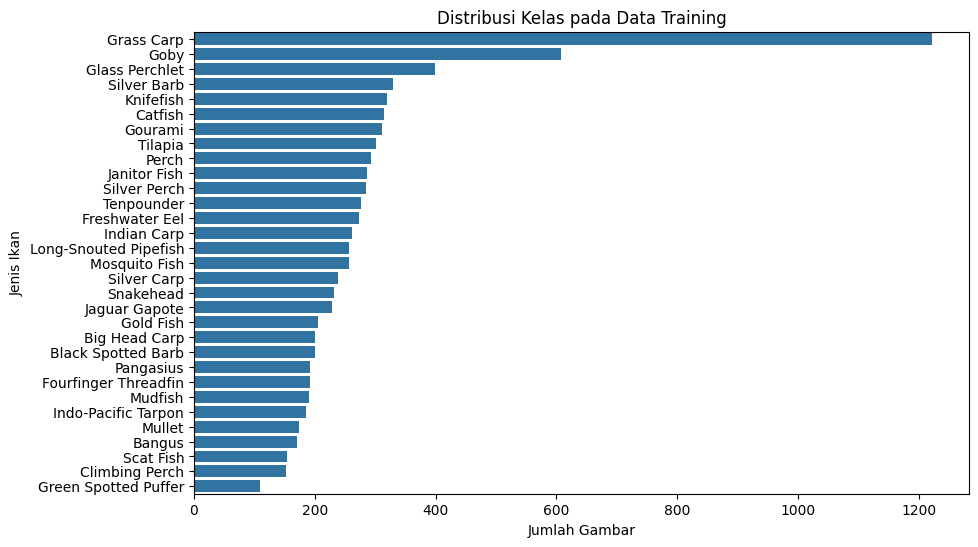

In [23]:
print("\nDistribusi kelas pada data training:")
# Filter hanya untuk data training
train_df = df[df['dataset'] == 'train']
print(train_df['label'].value_counts())

# Visualisasikan untuk pemahaman yang lebih baik
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(y=train_df['label'], order=train_df['label'].value_counts().index)
plt.title('Distribusi Kelas pada Data Training')
plt.xlabel('Jumlah Gambar')
plt.ylabel('Jenis Ikan')
plt.show()

# Preprocessing, Augmentasi, dan Membuat Pipeline Data

### Cek file gambar dan nongambar

In [24]:
import os

# Daftar ekstensi file gambar yang diizinkan
allowed_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

# Fungsi untuk mengecek apakah sebuah file punya ekstensi yang diizinkan
def is_image_file(filepath):
    # Mengambil ekstensi file (misal: '.jpg') dan mengubahnya ke huruf kecil
    ext = os.path.splitext(filepath)[1].lower()
    return ext in allowed_extensions

# Terapkan fungsi pengecekan ke kolom filepath dan cari yang BUKAN gambar
non_image_files = df[~df['filepath'].apply(is_image_file)]

if not non_image_files.empty:
    print("DITEMUKAN FILE BERMASALAH (BUKAN GAMBAR):")
    print(non_image_files)
else:
    print("Tidak ada file non-gambar yang ditemukan. Penyebabnya mungkin file gambar korup.")

DITEMUKAN FILE BERMASALAH (BUKAN GAMBAR):
                                                filepath         label dataset
1238   /content/Types of fish/FishImgDataset/train/Kn...     Knifefish   train
8019   /content/Types of fish/FishImgDataset/train/Si...  Silver Perch   train
8132   /content/Types of fish/FishImgDataset/train/Si...  Silver Perch   train
11572  /content/Types of fish/FishImgDataset/test/Bangus       unknown    test
11573  /content/Types of fish/FishImgDataset/test/Jag...       unknown    test
11574  /content/Types of fish/FishImgDataset/test/Gre...       unknown    test
11575  /content/Types of fish/FishImgDataset/test/Fre...       unknown    test
11576  /content/Types of fish/FishImgDataset/test/Gou...       unknown    test
11577  /content/Types of fish/FishImgDataset/test/Kni...       unknown    test
11578  /content/Types of fish/FishImgDataset/test/Til...       unknown    test
11579  /content/Types of fish/FishImgDataset/test/Cat...       unknown    test
11580  /co

### Feature Engineering pada Label (Encoding)

In [25]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Asumsikan Anda sudah memiliki DataFrame 'df' dari langkah pertama
# df = pd.DataFrame(data)

# ==============================================================================
#                      --- LANGKAH PERBAIKAN DIMULAI ---
# ==============================================================================
print(f"Jumlah data sebelum difilter: {len(df)}")

# Daftar ekstensi yang diizinkan (dalam huruf kecil)
allowed_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

# Filter DataFrame, hanya simpan baris yang filepath-nya diakhiri dengan ekstensi yang diizinkan
# str.lower() untuk memastikan pengecekan tidak case-sensitive (misal .JPG tetap masuk)
df_cleaned = df[df['filepath'].str.lower().apply(lambda x: x.endswith(allowed_extensions))].copy()

print(f"Jumlah data setelah difilter (hanya gambar): {len(df_cleaned)}")
print(f"Jumlah data yang dibuang: {len(df) - len(df_cleaned)}")

# GANTI DataFrame lama dengan yang sudah bersih
df = df_cleaned
# ==============================================================================
#                       --- LANGKAH PERBAIKAN SELESAI ---
# ==============================================================================


# SEKARANG, LANJUTKAN DENGAN KODE ANDA YANG SEBELUMNYA
# Contoh: Langkah Label Encoding
# all_known_labels = df[df['label'] != 'unknown']['label'].unique()
# ... (sisa kode Anda) ...

# ==============================================================================
#                               KODE PERBAIKAN
# ==============================================================================

# 1. Ambil SEMUA label unik dari seluruh dataset (kecuali 'unknown')
# Ini memastikan encoder tahu semua kemungkinan kelas ikan dari train dan val set.
all_known_labels = df[df['label'] != 'unknown']['label'].unique()

# 2. Latih (fit) LabelEncoder dengan semua label yang diketahui
label_encoder = LabelEncoder()
label_encoder.fit(all_known_labels)

# Simpan jumlah kelas
NUM_CLASSES = len(label_encoder.classes_)
print(f"Total kelas yang terdeteksi: {NUM_CLASSES}")

# Simpan pemetaan untuk referensi nanti (sangat penting!)
label_map = dict(zip(range(NUM_CLASSES), label_encoder.classes_))
print("\nPemetaan Label ke Angka:")
print(label_encoder.classes_)


# 3. Buat kolom baru untuk menampung hasil encoding
df['label_encoded'] = -1 # Inisialisasi dengan nilai default, misal -1

# 4. Terapkan transformasi HANYA pada data yang labelnya diketahui (train & val)
known_labels_mask = df['label'] != 'unknown'
df.loc[known_labels_mask, 'label_encoded'] = label_encoder.transform(df.loc[known_labels_mask, 'label'])

# ==============================================================================

# Cek hasilnya
print("\nDataFrame setelah encoding:")
# Tampilkan beberapa baris dari setiap dataset untuk memastikan
print(df[df['dataset']=='train'].head())
print(df[df['dataset']=='val'].head())
print(df[df['dataset']=='test'].head())

# Cek apakah ada nilai -1 di set train atau val (seharusnya tidak ada)
print("\nJumlah nilai -1 di train set:", len(df[(df['dataset']=='train') & (df['label_encoded'] == -1)]))
print("Jumlah nilai -1 di val set:", len(df[(df['dataset']=='val') & (df['label_encoded'] == -1)]))

Jumlah data sebelum difilter: 11603
Jumlah data setelah difilter (hanya gambar): 11570
Jumlah data yang dibuang: 33
Total kelas yang terdeteksi: 31

Pemetaan Label ke Angka:
['Bangus' 'Big Head Carp' 'Black Spotted Barb' 'Catfish' 'Climbing Perch'
 'Fourfinger Threadfin' 'Freshwater Eel' 'Glass Perchlet' 'Goby'
 'Gold Fish' 'Gourami' 'Grass Carp' 'Green Spotted Puffer' 'Indian Carp'
 'Indo-Pacific Tarpon' 'Jaguar Gapote' 'Janitor Fish' 'Knifefish'
 'Long-Snouted Pipefish' 'Mosquito Fish' 'Mudfish' 'Mullet' 'Pangasius'
 'Perch' 'Scat Fish' 'Silver Barb' 'Silver Carp' 'Silver Perch'
 'Snakehead' 'Tenpounder' 'Tilapia']

DataFrame setelah encoding:
                                            filepath   label dataset  \
0  /content/Types of fish/FishImgDataset/train/Ba...  Bangus   train   
1  /content/Types of fish/FishImgDataset/train/Ba...  Bangus   train   
2  /content/Types of fish/FishImgDataset/train/Ba...  Bangus   train   
3  /content/Types of fish/FishImgDataset/train/Ba...  Bang

### Fungsi Preprocessing dan Augmentasi

In [26]:
import tensorflow as tf

IMG_SIZE = 224 # Tentukan ukuran gambar yang konsisten

def preprocess_image(filepath, label):
    # Baca file
    image = tf.io.read_file(filepath)
    # Decode menjadi tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalisasi
    image = image / 255.0
    # One-hot encode labelnya
    label_one_hot = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label_one_hot

# Define the rotation layer outside the function for efficiency
rotation_layer = tf.keras.layers.RandomRotation(factor=0.2)

def augment_image(image, label):
    # Terapkan augmentasi HANYA pada gambar
    image = tf.image.random_flip_left_right(image)
    image = rotation_layer(image) # Apply random rotation using the layer
    image = tf.image.random_brightness(image, max_delta=0.2)
    # Pastikan nilai piksel tetap di [0,1]
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

### Membuat Pipeline Data

In [27]:
BATCH_SIZE = 32 # Jumlah gambar yang diproses dalam satu iterasi

# Pisahkan DataFrame berdasarkan set
train_df = df[df['dataset'] == 'train']
val_df = df[df['dataset'] == 'val']
test_df = df[df['dataset'] == 'test']

# --- Membuat Pipeline Training ---
train_ds = tf.data.Dataset.from_tensor_slices((train_df['filepath'], train_df['label_encoded']))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# BARU (Startup jauh lebih cepat)
BUFFER_SIZE = 1024 # Ukuran buffer yang umum dan baik
train_ds = train_ds.shuffle(buffer_size=BUFFER_SIZE)
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) # Terapkan augmentasi
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE) # Optimasi performa

# --- Membuat Pipeline Validasi ---
val_ds = tf.data.Dataset.from_tensor_slices((val_df['filepath'], val_df['label_encoded']))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# --- Membuat Pipeline Test ---
test_ds = tf.data.Dataset.from_tensor_slices((test_df['filepath'], test_df['label_encoded']))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Pipeline data siap!")
print("Contoh satu batch data training (gambar, label):", next(iter(train_ds)))

Pipeline data siap!
Contoh satu batch data training (gambar, label): (<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.6412603 , 0.58635837, 0.48439753],
         [0.63740844, 0.5825065 , 0.4805457 ],
         [0.63198364, 0.5749899 , 0.4793045 ],
         ...,
         [0.35638565, 0.28573257, 0.32956842],
         [0.3483103 , 0.28130898, 0.3280787 ],
         [0.37236482, 0.30953643, 0.36100805]],

        [[0.64332855, 0.5884266 , 0.4864658 ],
         [0.63988364, 0.5849817 , 0.4830209 ],
         [0.6352463 , 0.57909524, 0.4808817 ],
         ...,
         [0.33337578, 0.268997  , 0.32776582],
         [0.33157495, 0.27222288, 0.33104858],
         [0.34529307, 0.29177552, 0.34679314]],

        [[0.64572793, 0.590826  , 0.4888652 ],
         [0.6431055 , 0.58820355, 0.48624277],
         [0.6387972 , 0.5834889 , 0.4827472 ],
         ...,
         [0.32168347, 0.26638752, 0.33038843],
         [0.32994908, 0.28556335, 0.33813775],
         [0.33695394, 0.30

# Modelling

## Bangun Model Menggunakan Transfer Learning (MobileNetV2)

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

# Tentukan bentuk input sesuai dengan data kita
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3) # IMG_SIZE dari langkah sebelumnya, yaitu 224

# 1. Muat model dasar (base model) MobileNetV2 yang sudah dilatih di ImageNet
# include_top=False artinya kita tidak menyertakan layer klasifikasi aslinya (yang punya 1000 kelas)
base_model = MobileNetV2(input_shape=INPUT_SHAPE,
                         include_top=False,
                         weights='imagenet')

# 2. Bekukan (freeze) semua layer di model dasar
# Kita tidak ingin melatih ulang apa yang sudah ia pelajari
base_model.trainable = False

# 3. Tambahkan layer klasifikasi baru di atas model dasar
# Ini adalah bagian yang akan kita latih
x = base_model.output
x = GlobalAveragePooling2D()(x) # Meratakan output fitur menjadi satu vektor
x = Dropout(0.3)(x) # Dropout untuk mengurangi overfitting (30% neuron dimatikan acak)
# Layer output dengan jumlah neuron sebanyak jumlah kelas kita (NUM_CLASSES)
# dan aktivasi softmax untuk klasifikasi multi-kelas
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# 4. Gabungkan menjadi model akhir
model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compile model
# Tentukan optimizer, fungsi loss, dan metrik yang ingin dipantau
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', # Cocok untuk label one-hot
              metrics=['accuracy'])

# 6. Tampilkan arsitektur model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,297,695 (8.77 MB)

 Trainable params: 39,711 (155.12 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Latih Model dengan model.fit()

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Tentukan jumlah epoch
EPOCHS = 20

# Callback untuk menyimpan model terbaik
# File 'best_model.keras' akan berisi model dengan val_accuracy tertinggi
model_checkpoint = ModelCheckpoint(filepath='best_model.keras',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   verbose=1)

# Callback untuk berhenti lebih awal
# 'patience=5' berarti training akan berhenti jika val_accuracy tidak naik selama 5 epoch berturut-turut
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

# Latih model dengan callbacks
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.3938 - loss: 2.4244
Epoch 1: val_accuracy improved from -inf to 0.31988, saving model to best_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 123s 375ms/step - accuracy: 0.3940 - loss: 2.4241 - val_accuracy: 0.3199 - val_loss: 2.6705
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5912 - loss: 1.6391
Epoch 2: val_accuracy improved from 0.31988 to 0.38168, saving model to best_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 120s 307ms/step - accuracy: 0.5914 - loss: 1.6379 - val_accuracy: 0.3817 - val_loss: 2.1496
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.6733 - loss: 1.1984
Epoch 3: val_accuracy improved from 0.38168 to 0.45874, saving model to best_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 154s 350ms/step - accuracy: 0.6734 - loss: 1.1978 - val_accuracy: 0.4587 - val_loss: 1.8118
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7256 - loss: 1.0125
Epoch 4: val_accuracy

# Evaluasi dan Analisa Hasi

## Membuat Grafik Hasil Training

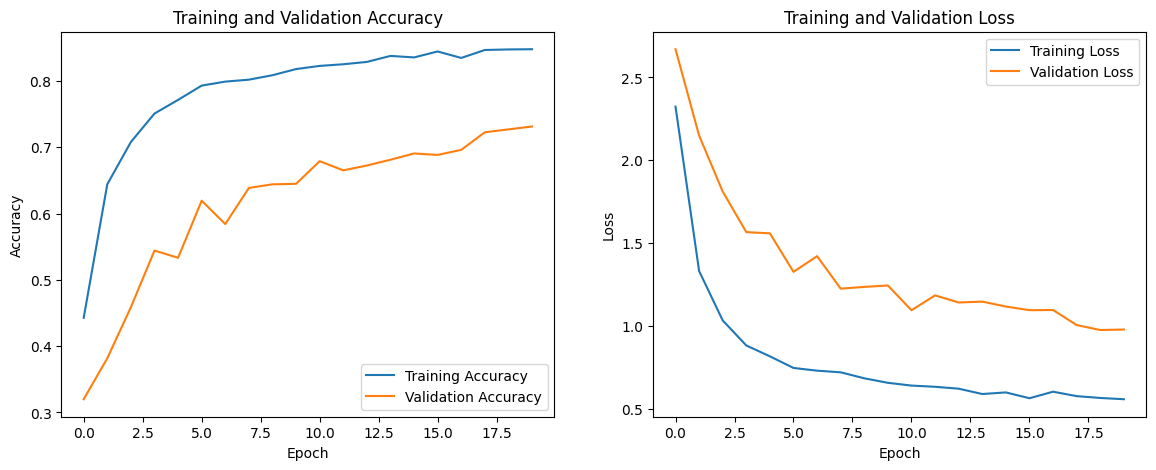

In [30]:
import matplotlib.pyplot as plt

# Ambil data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Buat plot akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Buat plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Evaluasi dengan Data Test dan Membuat Confusion Matrix

In [36]:
# Cek jumlah baris di dataframe test setelah dibersihkan
print(f"Jumlah data di test_df: {len(test_df)}")

Jumlah data di test_df: 0


Mengapa Dataset Test Anda Kosong?

Kemungkinan besar ini adalah efek samping dari langkah pembersihan data yang kita lakukan sebelumnya. Mari kita runut kembali:

Awalnya, Anda memiliki 31 file di dalam folder test.
Kita menjalankan skrip diagnosis untuk mencari file non-gambar, dan output Anda menunjukkan bahwa banyak (atau bahkan semua) file dari folder test terdeteksi sebagai file bermasalah.
Kita kemudian menjalankan kode pembersihan yang menghapus semua baris yang merujuk pada file bermasalah dari DataFrame df.
Akibatnya, setelah dibersihkan, tidak ada lagi data yang berasal dari set test. Saat Anda membuat test_df, DataFrame tersebut menjadi kosong.

Membuat "Test Set" Baru dari Data Validasi
Karena data test asli Anda tidak dapat digunakan, kita perlu cara lain untuk mengevaluasi model pada data yang "benar-benar baru". Praktik yang umum dan bisa diterima dalam situasi ini adalah dengan mengambil sebagian kecil dari data validasi untuk dijadikan sebagai data test baru.

In [34]:
from sklearn.model_selection import train_test_split

# Kita sudah punya val_df dari langkah sebelumnya.
# Cek dulu ukurannya.
print(f"Ukuran validation set awal (val_df): {len(val_df)}")

# 1. Pisahkan val_df menjadi set validasi baru dan set test baru.
# Kita ambil 20% dari val_df untuk dijadikan test set.
# 'random_state' untuk memastikan hasil split selalu sama.
new_val_df, new_test_df = train_test_split(val_df, test_size=0.2, random_state=42)

print(f"Ukuran validation set baru (setelah dipisah): {len(new_val_df)}")
print(f"Ukuran test set baru yang kita buat: {len(new_test_df)}")

# 2. Buat ulang pipeline data 'val_ds' dan 'test_ds' dengan dataframe baru.
# Ini langkah yang sangat penting!

# --- Pipeline Validasi BARU ---
val_ds = tf.data.Dataset.from_tensor_slices((new_val_df['filepath'], new_val_df['label_encoded']))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# --- Pipeline Test BARU ---
test_ds = tf.data.Dataset.from_tensor_slices((new_test_df['filepath'], new_test_df['label_encoded']))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("\nPipeline 'val_ds' dan 'test_ds' telah berhasil dibuat ulang dengan data baru.")

Ukuran validation set awal (val_df): 2751
Ukuran validation set baru (setelah dipisah): 2200
Ukuran test set baru yang kita buat: 551

Pipeline 'val_ds' dan 'test_ds' telah berhasil dibuat ulang dengan data baru.


Mengevaluasi model dengan data test...
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 309ms/step - accuracy: 0.6882 - loss: 1.1271

Test Accuracy: 71.51%
Test Loss: 1.0379

Membuat prediksi untuk data test...
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step

Laporan Klasifikasi Lengkap:
                       precision    recall  f1-score   support

               Bangus       1.00      0.29      0.44         7
        Big Head Carp       0.47      1.00      0.64         8
   Black Spotted Barb       0.91      0.77      0.83        13
              Catfish       1.00      0.53      0.69        17
       Climbing Perch       1.00      0.64      0.78        11
 Fourfinger Threadfin       0.60      0.90      0.72        10
       Freshwater Eel       0.92      0.57      0.71        21
       Glass Perchlet       0.81      0.97      0.88        30
                 Goby       0.83      0.45      0.59        33
            Gold Fish       1.00      0.91      0.95        11
              Gourami       1.00      0.55

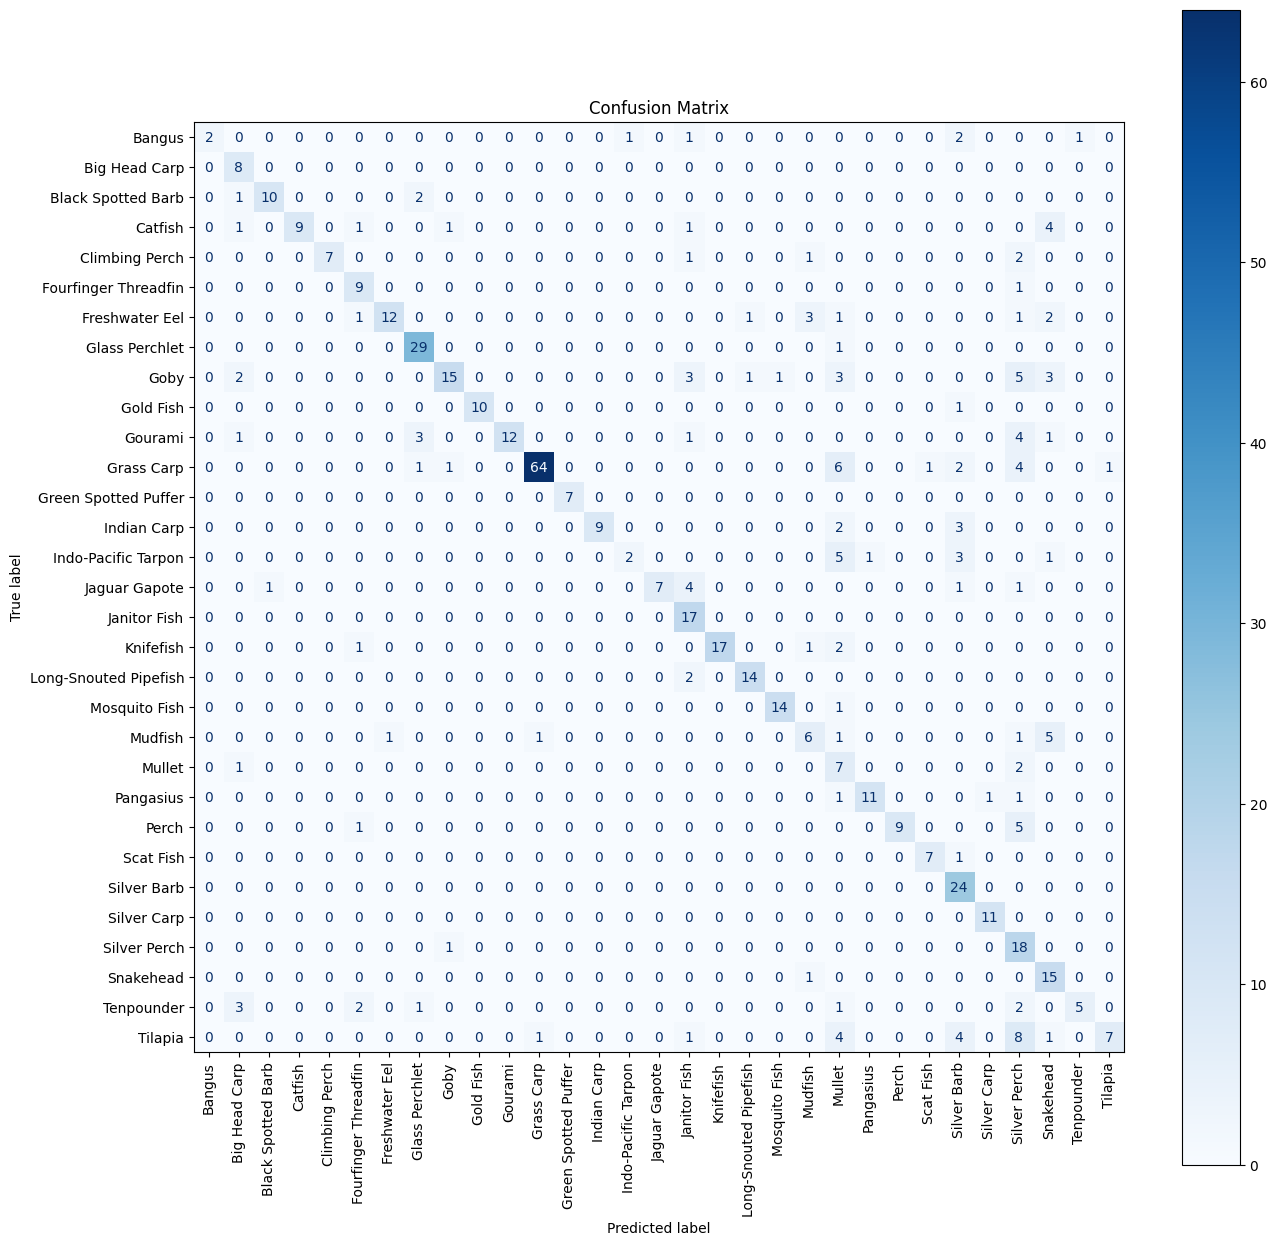

In [35]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Muat model terbaik yang telah disimpan
best_model = load_model('best_model.keras')

# Lakukan evaluasi pada data test
print("Mengevaluasi model dengan data test...")
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Untuk membuat classification report dan confusion matrix, kita butuh prediksi dan label asli
print("\nMembuat prediksi untuk data test...")
# Dapatkan semua label asli dari test_ds
y_true = np.concatenate([y for x, y in test_ds], axis=0)
# Ubah dari one-hot ke label integer
y_true_labels = np.argmax(y_true, axis=1)

# Dapatkan prediksi dari model
y_pred_probs = best_model.predict(test_ds)
# Ubah dari probabilitas ke label integer
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Dapatkan nama-nama kelas dari label encoder yang kita buat sebelumnya
class_names = label_encoder.classes_

# 1. Tampilkan Classification Report (Accuracy, Precision, Recall, F1-Score)
print("\nLaporan Klasifikasi Lengkap:")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

# 2. Visualisasikan Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Kesimpulan

### **Kesimpulan dan Analisa Akhir Proyek Klasifikasi Ikan**

Secara keseluruhan, model yang dibangun berhasil mencapai performa yang **cukup baik** untuk tugas klasifikasi 31 jenis ikan yang kompleks, dengan **akurasi final pada data test sebesar 71.51%**. Namun, analisa lebih dalam menunjukkan adanya beberapa area yang bisa ditingkatkan, terutama terkait *overfitting* dan kesulitan dalam membedakan beberapa kelas ikan yang mirip.

Berikut adalah rincian analisanya:

#### **1. Analisa Performa Training (dari Grafik Akurasi & Loss)**

Grafik yang Anda hasilkan memberikan wawasan penting tentang bagaimana model belajar:
* **Grafik Akurasi:** Garis akurasi training (biru) secara konsisten berada di atas dan terus menanjak hingga ~85%, sementara garis akurasi validasi (oranye) naik namun lebih landai dan berakhir di sekitar ~73%.
* **Grafik Loss:** Sama halnya, garis loss training (biru) turun dengan sangat rendah, sementara loss validasi (oranye) turun lalu cenderung stagnan di level yang lebih tinggi.

**Kesimpulan dari Grafik:** Terdapat **celah (gap) yang jelas** antara kurva training dan validasi. Ini adalah indikator klasik dari **moderate overfitting**. Artinya, model menjadi sedikit terlalu "hafal" dengan data training, sehingga kemampuannya untuk menggeneralisasi pada data baru (data validasi) sedikit kurang optimal. Meskipun demikian, `EarlyStopping` kemungkinan telah membantu mencegah overfitting yang lebih parah.

#### **2. Analisa Performa per Kelas (dari Laporan Klasifikasi & Confusion Matrix)**

Di sinilah kita melihat kekuatan dan kelemahan model secara mendetail.

**Kelas dengan Performa Terbaik:**
Model menunjukkan performa yang sangat baik untuk beberapa kelas, ditandai dengan F1-Score yang tinggi:
* `Green Spotted Puffer` (F1-score: 1.00)
* `Silver Carp` (F1-score: 0.96)
* `Gold Fish` (F1-score: 0.95)
* `Mosquito Fish` (F1-score: 0.93)
Ini kemungkinan karena ikan-ikan ini memiliki ciri visual yang sangat unik dan mudah dibedakan.

**Kelas dengan Performa Bermasalah:**
Model mengalami kesulitan signifikan pada beberapa kelas berikut:
* `Indo-Pacific Tarpon` (F1-score: 0.27)
* `Mullet` (F1-score: 0.31)
* `Tilapia` (F1-score: 0.41)
* `Silver Perch` (F1-score: 0.49)
Rendahnya F1-score menunjukkan bahwa model sering salah dalam mengidentifikasi ikan-ikan ini, baik karena salah tebak maupun gagal mengenali.

**Analisa Kebingungan Model (dari Confusion Matrix):**
* **Kemiripan Visual:** Model tampak bingung antara beberapa jenis ikan yang mungkin mirip. Contohnya, dari matriks, terlihat ada kebingungan antara `Silver Perch`, `Perch`, dan `Silver Barb`.
* **Kasus Unik `Silver Perch`:** Kelas ini memiliki `recall` sangat tinggi (0.95) tetapi `precision` sangat rendah (0.33). Artinya: Model sangat pandai **menemukan** hampir semua `Silver Perch` yang ada, tetapi ia melakukannya dengan "harga" sering salah melabeli ikan lain sebagai `Silver Perch`.
* **Kasus Unik `Big Head Carp`:** Kebalikannya, kelas ini punya `recall` 1.00 tapi `precision` hanya 0.47. Artinya: Model **menemukan semua** `Big Head Carp`, tetapi tebakannya sering meleset (lebih dari 50% tebakan `Big Head Carp` ternyata adalah ikan lain).

#### **3. Jawaban Soal: Matriks Evaluasi Terbaik**

Tidak ada satu matriks "terbaik" yang universal; pilihannya sangat bergantung pada **tujuan dan konteks bisnis** dari masalah yang ingin diselesaikan.

* **Accuracy (Akurasi):** Metrik ini (71.51%) memberikan gambaran umum performa model di semua kelas. Ini adalah metrik yang baik jika **semua kelas sama pentingnya** dan **jumlah data per kelas relatif seimbang**. Namun, akurasi bisa menyesatkan jika ada kelas yang sangat dominan.

* **Precision vs. Recall:** Ini adalah metrik yang lebih bernuansa.
    * **Pilih Precision** jika **konsekuensi dari *False Positive* sangat tinggi**. Contoh konteks: "Menjual ikan yang salah label sebagai jenis premium yang mahal." Anda ingin memastikan bahwa jika model melabeli ikan sebagai "Tuna Sirip Biru", ikan itu **benar-benar** Tuna Sirip Biru. Dalam kasus ini, `Bangus` (precision 1.00) adalah contoh performa yang ideal.
    * **Pilih Recall** jika **konsekuensi dari *False Negative* sangat tinggi**. Contoh konteks: "Mengidentifikasi ikan beracun untuk disingkirkan." Anda ingin memastikan **semua** ikan beracun teridentifikasi, meskipun itu berarti Anda kadang salah mengira ikan aman sebagai ikan beracun. Dalam kasus ini, performa pada `Big Head Carp` (recall 1.00) adalah yang diinginkan.

* **F1-Score:** Ini adalah penengah yang baik antara Precision dan Recall. **Untuk kasus klasifikasi umum seperti ini, di mana tidak ada konteks bisnis spesifik, F1-Score (terutama `weighted avg`) seringkali menjadi matriks pilihan terbaik.** Ini memberikan gambaran performa yang seimbang dengan mempertimbangkan baik *False Positive* maupun *False Negative*, serta memperhitungkan ketidakseimbangan jumlah data antar kelas (`weighted avg`). Dalam kasus Anda, `weighted avg f1-score` adalah **0.72**, yang sejalan dengan akurasi dan merupakan ringkasan performa yang solid.

### **Rekomendasi Langkah Selanjutnya**

1.  **Mengatasi Overfitting:** Coba teknik augmentasi data yang lebih agresif atau tingkatkan nilai `Dropout` pada model.
2.  **Menangani Kelas Lemah:** Kumpulkan lebih banyak data gambar untuk kelas-kelas dengan F1-score rendah seperti `Indo-Pacific Tarpon` dan `Mullet`.
3.  **Fine-Tuning:** Setelah beberapa epoch awal, coba "buka" (unfreeze) beberapa layer terakhir dari model MobileNetV2 dan latih kembali dengan *learning rate* yang sangat kecil. Ini dapat membantu model mempelajari fitur yang lebih spesifik untuk dataset ikan Anda.

Anda telah berhasil menyelesaikan sebuah proyek machine learning end-to-end yang kompleks. Selamat!